## TF GPU setting

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 1 Logical GPU


## pymc3 Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

In [2]:

model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [3]:

with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=6)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu1]
Sampling 6 chains, 0 divergences: 100%|██████████| 18000/18000 [00:04<00:00, 3734.05draws/s]


In [4]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

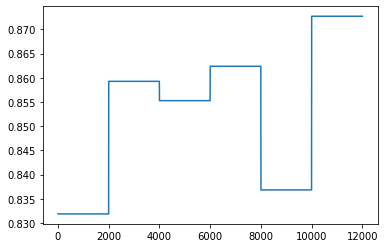

In [5]:
plt.plot(trace['step_size_bar'])

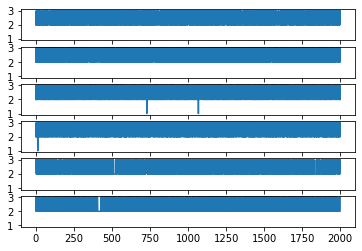

In [7]:
sizes1, sizes2, sizes3, sizes4, sizes5, sizes6 = trace.get_sampler_stats('depth', combine=False)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, sharey=True)
ax1.plot(sizes1)
ax2.plot(sizes2)
ax3.plot(sizes3)
ax4.plot(sizes4)
ax5.plot(sizes5)
ax6.plot(sizes6)

## pymc4 logistic model

In [ ]:
import numpy as np
import pymc4 as pm4
import tensorflow as tf
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data["data"].astype('float32')
# Standardize to avoid overflow issues
X -= X.mean(0)
X /= X.std(0)
y = data["target"]

n_samples, n_features = X.shape

X = tf.constant(X)


@pm4.model
def logistic_model():
    w = yield pm4.Normal("w", np.zeros(n_features, 'float32'), 0.01 * np.ones(n_features, 'float32'))

    z = tf.linalg.matvec(X, w)
    p = tf.math.sigmoid(z)

    obs = yield pm4.Bernoulli("obs", p, observed=y)
    return obs


def test_sample():
    tf_trace = pm4.inference.sampling.sample(
        logistic_model(), step_size=0.01, num_chains=1, num_samples=200, burn_in=0, xla=False
    )
    return tf_trace

tr = test_sample()

## pymc3 LDA

In [1]:
%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


In [5]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))


Loading dataset...
done in 12.069s.
Extracting tf features for LDA...
done in 3.872s.


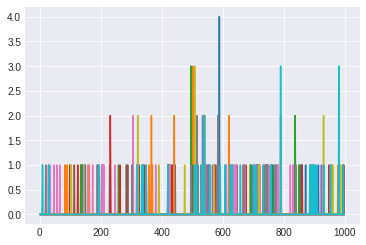

In [6]:
plt.plot(tf[:10, :].toarray().T);

In [7]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480263
Sparsity = 0.0253936


In [8]:

def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()

        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

    return ll_docs_f

In [9]:

n_topics = 10
# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_samples_tr)
    beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)


/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

In [10]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [11]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [12]:
encoder_params = encoder.get_params()
encoder_params


[w0, b0, w1, b1]

In [13]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t: doc_t_minibatch})


  0%|          | 0/10000 [00:00<?, ?it/s]/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.9831e+06: 100%|██████████| 10000/10000 [19:29<00:00,  8.55it/s]
Finished [100%]: Average Loss = 2.9862e+06


In [14]:
print(approx)

Approximation{MeanFieldGroup[None, 9] & MeanFieldGroup[9990]}


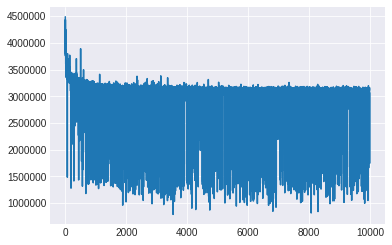

In [15]:
plt.plot(approx.hist[10:]);

In [16]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: people think god don just said know say time like
Topic #1: use file windows drive scsi program using does like edu
Topic #2: key space edu use information encryption new chip com data
Topic #3: 00 10 25 11 17 15 20 12 16 14
Topic #4: year team like good just game car don time think
Topic #5: like know don just good think does ve new thanks
Topic #6: ax max g9v b8f 75u a86 bhj 1t 1d9 pl
Topic #7: like just know don good think does thanks new ve
Topic #8: like just know don good does think new thanks ve
Topic #9: don like know just good does think edu new thanks


## Corr LDA

In [1]:
# %matplotlib inline
# import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
# %env THEANO_FLAGS=device=cpu,floatX=float64
import theano

# from collections import OrderedDict
# from copy import deepcopy
# import numpy as np
# from time import time
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.datasets import fetch_20newsgroups
# import matplotlib.pyplot as plt
# import seaborn as sns
# from theano import shared
# import theano.tensor as tt
# from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
# from pymc3 import math as pmmath
# from pymc3 import Dirichlet
# from pymc3 import Beta
import theano.tensor as tt
# from pymc3.distributions.transforms import t_stick_breaking
# plt.style.use('seaborn-darkgrid')

In [2]:
## ADVI log
def log_lda(theta,phi):
    def ll_lda(value):  
        dixs, vixs = value.nonzero()
        vfreqs = value[dixs, vixs]
        ll =vfreqs* pm.math.logsumexp(t.log(theta[dixs]) + t.log(phi.T[vixs]), axis = 1).ravel()
        return t.sum(ll) 
    return ll_lda
    

In [2]:
import numpy as np
import pandas as pd
import re
from os.path import join

from tools import *

## rename EXTRACT_FEATURES to DIMENSION_REDUCTION
read_prefix = "/data/MIMIC3/"
write_prefix = "/data/liu/LDA"
res_prefix = "/data/liu/LDA/lda_result"
res_r_prefix = "/data/liu/LDA/lda_R_result/"

In [3]:
## simulated test data
# pres_data = np.random.randint(2,size=(10,19))
# diag_data = np.random.randint(2,size =(10,32))

In [3]:
diag_data=read_data(join(write_prefix, "diagample1000")).values
diag_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
pres_data=read_data(join(write_prefix,"pressample1000")).values

In [5]:
print(pres_data.shape)
print(diag_data.shape)

(1000, 829)
(1000, 1309)


In [ ]:
### Random sample zdi from zd for each patient
D,S = pres_data.shape
D, tS = diag_data.shape

# K=4
# tK=5

# alpha = 0.1
# b_0, b_1 = 0.1, 0.1
# gamma = 0.1
# tb_0, tb_1 = 0.1, 0.1
K =10
tK=15

alpha =0.01
b_0,b_1=0.01, 0.01
gamma=0.01
tb_0,tb_1=0.01,0.01

def p_vector(p,n):
    return p * np.ones((1,n))

with pm.Model() as model:
    
    
#     p_alpha = alpha * np.ones((1, K))
#     p_beta = pm.Beta('p_beta', alpha=b_0, beta=b_1, shape=(K, S))
    
    theta = pm.Dirichlet("theta", a=p_vector(alpha,K), shape=(D, K))
#     phi = pm.distributions.Dirichlet('phi', a=p_beta, shape=(K, S))
    phi = pm.Beta('phi', alpha=b_0, beta=b_1, shape=(K, S))
    psi = pm.Dirichlet("psi",a=p_vector(gamma,tK),shape=(K,tK))
    tphi = pm.Beta("tphi", alpha=tb_0, beta=tb_1, shape=(tK, tS))
    
    # For each DRUG <theta>: D*K
    zs = [pm.Categorical("z_d{}".format(d), p=theta[d], shape=S) for d in range(D)]
    ws = [pm.Bernoulli("w_{}_{}".format(d,i), p=phi[zs[d][i]], observed=pres_data[d][i]) 
          for d in range(D) for i in range(S)]
    
    # For each disease random.choice(zs[d]) <psi>: K*tK
    tzs = [pm.Categorical("tz_d{}".format(d), p=psi[zs[d][np.random.randint(S)]], shape=tS) for d in range(D)]
    tws = [pm.Bernoulli("tw_{}_{}".format(d,i), p=tphi[tzs[d][i]], observed=diag_data[d][i]) 
          for d in range(D) for i in range(tS)]
    



In [6]:
### uniform get zdi from zd for each disease in each drug
D, S = pres_data.shape
D, tS = diag_data.shape

K =10
tK=15

alpha =0.01
b_0,b_1=0.01, 0.01
gamma=0.01
tb_0,tb_1=0.01,0.01

def p_vector(p,n):
    return p * np.ones((1,n))

# def psi_k()

def pij(zsd,phi,s):
    return phi[zsd[s]][s]

## get actual drug topic for each document: mat D*tS*D
def nd3_2(mat,D,tS):
    return tt.reshape([mat[d,:,d] for d in range(D)],(D,tS))


with pm.Model() as model:
    
    theta = pm.Dirichlet("theta", a=p_vector(alpha,K), shape=(D, K))
    phi = pm.Beta('phi', alpha=b_0, beta=b_1, shape=(K, S))
    psi = pm.Dirichlet("psi",a=p_vector(gamma,tK),shape=(K,tK))
    tphi = pm.Beta("tphi", alpha=tb_0, beta=tb_1, shape=(tK, tS))
    
    ## For each DRUG <theta>: D*K,  sample(theta_d)->column d
    zs=pm.Categorical("zs",p=theta,shape=(S,D))
    ws=[pm.Bernoulli("ws_{}_{}".format(d,s),p=pij(zs.T[d],phi,s),observed=pres_data[d][s]) for d in range(D) for s in range(S)]
    
    ## For each disease random.choice(zs[d]) <psi>: K*tK
    sp_zs_idx = pm.DiscreteUniform("super_z", lower=np.zeros([D,tS]), upper=np.ones([D,tS])*S,shape=(D,tS))
    ## Map idx to z_s, each z_s is vector with length of D, s is from 1 to S
    super_zs = nd3_2(zs[sp_zs_idx],D,tS) #shape:(D*tS*D) -> (D,tS)
    
    tzs = pm.Categorical("tzs", p=psi[super_zs],shape=(D,tS)) 
    tws = [pm.Bernoulli("tw_{}_{}".format(d,ts), p=pij(tzs[d],tphi,ts), observed=diag_data[d][ts]) 
          for d in range(D) for ts in range(tS)]

/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/liu/anaconda3/envs/tfgpu21/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


KeyboardInterrupt: 

In [ ]:
with model:
#     step = pm.metropolis.CategoricalGibbsMetropolis(zs+ws+tzs+tws)
    trace=pm.sample(200, init=None, cores=1)

In [ ]:
write2file(pd.DataFrame(trace["phi"][599]), join(write_prefix,"corrlda_presphi"))

In [ ]:
write2file(pd.DataFrame(trace['theta'][599]),join(write_prefix,"corrlda_prestheta"))

In [ ]:
write2file(pd.DataFrame(trace["psi"][599]),join(write_prefix,"corrlda_diagtheta"))

In [ ]:
write2file(pd.DataFrame(trace["tphi"][599]),join(write_prefix,"corrlda_diagphi"))

In [1]:

# n_patients = data.shape[0]
# n_items = data.shape[1]
# n_topics = 6
# alpha = np.ones(n_topics) * 0.01
# alpha1=0.01
# alpha2=0.02



# # defining minibatch

# with pm.Model() as model:
#     theta = Dirichlet('theta', a=alpha, shape=(n_patients,n_topics))
#     phi = Beta("phi",alpha=alpha1,beta=alpha2, shape=(n_topics, n_items))
    
#     # Pick topics for each patient
#     z = pm.Categorical("zx",p=theta,shape=(n_items, n_patients))
#     w = pm.Bernoulli("wx",p=t.reshape(phi[z.T], (n_patients*n_items,n_items)),observed=data.reshape(n_patients*n_items))

#     # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
# #     patients = pm.DensityDist('patient', log_lda(theta,phi), observed=data)


In [32]:
phi.shape[0]

Subtensor{int64}.0

In [2]:
# with model:
#     step = pm.metropolis.CategoricalGibbsMetropolis([z,w])
#     trace = pm.sample(500, step=step,init=None, cores=4)
#     pm.plots.traceplot(trace, ['thetas','phis'])

In [ ]:
# alpha = np.ones(K) * 0.01
# beta = np.ones(V) * 0

# with pm.Model() as model:
#     phi = pm.Dirichlet("phi", a=beta, shape=(K, V))

#     for i in range(D):
#         theta = pm.Dirichlet(f"theta_{i}", a=alpha)
        
#         z = pm.Categorical(f"z_{i}", p=theta, shape=X[i].shape)
#         w = pm.Categorical(f"w_{i}", p=phi[z], observed=X[i])

In [17]:
# with model:    
#     trace = pm.sample(2000, chains=1, nuts_kwargs={'target_accept': 0.9})